# checkfile

In [70]:
import os

def checkfile(path):
    path = os.path.expanduser(path)

    if not os.path.exists(path):
        return path

    root, ext = os.path.splitext(os.path.expanduser(path))
    dir       = os.path.dirname(root)
    fname     = os.path.basename(root)
    candidate = fname+ext
    index     = 0
    ls        = set(os.listdir(dir))
    while candidate in ls:
            candidate = "{}_{}{}".format(fname,index,ext)
            index    += 1
    return os.path.join(dir,candidate)

In [82]:
checkfile("./Dockerfile")

'./Dockerfile_0'

In [83]:
import self_code
fn = "./Dockerfile"
fn = self_code.checkfile(fn)
print(fn)

./Dockerfile_0


In [38]:
import self_code
fn = "./run_glue.py"
fn = self_code.checkfile(fn)
print(fn)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


./run_glue_0.py


# between_str()

In [20]:
def between_str(string:str, substr1:str, substr2:str):
    '''
    Only able to detect the first occurence of substr
    '''
    try:
        idx1 = string.index(substr1)
        idx2 = string.index(substr2)
    except ValueError:
        return ''
    
    return string[idx1 + len(substr1): idx2]


In [50]:
string = "abckioki_10.pth"
between_str(string, "_", ".pth")

'10'

In [24]:
string = "abckioki.pth"
between_str(string, "_", ".pth")

''

In [25]:
string = "abckioki.pth"
if between_str(string, "_", ".pth") != '':
    print("Not empty")

# after_str

In [31]:
def after_str(string:str, substr1:str):
    '''
    Only able to detect the first occurence of substr
    '''
    try:
        idx1 = string.index(substr1)
    except ValueError:
        return ''
    
    return string[idx1 + len(substr1):]

In [32]:
string = "abckioki_10"
after_str(string, "_")

'10'

In [36]:
string = "abckioki"
if "_" in string:
    after_str(string, "_")
else:
    print("No _")

No _


In [1]:
import self_code

mode = "only-correct"
num_examples_to_test = 3
s_test_num_samples = 1000

folder = "experiments_outputs/"
fn = f"KNN-recall.{mode}.{num_examples_to_test}.{s_test_num_samples}.collections.pth"

path = self_code.checkfile(folder+fn)
fn = self_code.after_str(path, folder)

if "_" in fn:
    ext = self_code.between_str(fn, "_", ".pth")
    print(ext)
    ext = int(ext)
    next_starting_test_index = (ext + 1) * num_examples_to_test
    # Ex: num_examples_to_test = 3; and I ran the code once before
    # then, my ext == 0 (see how checkfile works), next_starting_test_index = 3


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


experiments_outputs/KNN-recall.only-correct.3.1000.collections_0.pth
KNN-recall.only-correct.3.1000.collections_0.pth
0
KNN-recall.only-correct.3.1000.collections_0.pth
3


# Recall @ m

In [1]:
from typing import List, Dict, Tuple, Optional, Union, Any
from experiments import influence_helpers
from experiments import misc_utils
from experiments import constants
from tqdm import tqdm

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def recall(ms:List[int],
            ks:List[int], 
            output_collections: Dict[int, Dict[str, Any]]) -> Dict[int, Dict[int, Any]]:
    
    tokenizer, model = misc_utils.create_tokenizer_and_model(
        constants.MNLI_MODEL_PATH)
    
    (mnli_train_dataset,
     mnli_eval_dataset) = misc_utils.create_datasets(
        task_name="mnli",
        tokenizer=tokenizer)

    faiss_index = influence_helpers.load_faiss_index(
        trained_on_task_name="mnli",
        train_task_name="mnli")
    
    eval_instance_data_loader = misc_utils.get_dataloader(
        dataset=mnli_eval_dataset,
        batch_size=1,
        random=False)
    
    mk_dict = {m:{k:([],[],[]) for k in ks} for m in ms}
        
    for test_index, outputs in tqdm(output_collections.items()):
            
        # top m
        influences = outputs["influences"] #Thean: influence={train_index:influence_val}
        # helpful and harmful
        try:
            helpful_indices, harmful_indices = misc_utils.get_helpful_harmful_indices_from_influences_dict(influences, n = max(ms))
        except ValueError as error:
            print(repr(error) +" at test_index "+str(test_index))
            continue
        # top influential s
        sorted_abs_indices = [key for key,_ in sorted(influences.items(), key=lambda item: abs(item[1]), reverse = True)]
        influential_indices = sorted_abs_indices # alias
        
        # top_k
        for eval_index, eval_inputs in enumerate(eval_instance_data_loader):
            if eval_index == test_index:
                test_inputs = eval_inputs
                break

        features = misc_utils.compute_BERT_CLS_feature(model, **test_inputs)
        features = features.cpu().detach().numpy()

        # Thean: the KNN_indices is equivalent to train_indices
        _, KNN_indices = faiss_index.search(k=max(ks), queries=features)

        # Flatten out list; it originally looks like [[3455,4903,...]]
        KNN_indices = KNN_indices[0]

        # Calculate recalls
        for m in ms:
            
            top_m_help = helpful_indices[:m]
            top_m_harm = harmful_indices[:m]
            top_m_influential = influential_indices[:m]
            
            for k in ks:
                top_k = KNN_indices[:k]
                
                helpful_score = len(intersection(top_k, top_m_help))/m
                harmful_score = len(intersection(top_k, top_m_harm))/m
                influential_score = len(intersection(top_k, top_m_influential))/m

                recall_helpful, recall_harmful, recall_influential = mk_dict[m][k]
                recall_helpful.append(helpful_score)
                recall_harmful.append(harmful_score)
                recall_influential.append(influential_score)
  
                mk_dict[m][k] = recall_helpful, recall_harmful, recall_influential
                
    
    return mk_dict

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
'''
outputs_collections = {
    test_index:{"test_index": test_index,
                "influences": influences,  #Thean: influence={train_index:influence_val}
                "s_test": s_test,
                "time": timer.elapsed,
                "correct": prediction_is_correct},
    ...
}
'''

'\noutputs_collections = {\n    test_index:{"test_index": test_index,\n                "influences": influences,  #Thean: influence={train_index:influence_val}\n                "s_test": s_test,\n                "time": timer.elapsed,\n                "correct": prediction_is_correct},\n    ...\n}\n'

# Combine outputs

In [10]:
import glob
import torch
import self_code

correct_output_collections={}
for name in glob.glob('experiments_outputs/KNN-recall.only-correct.3.1000.*'):
    tmp = torch.load(name)
    #print(name)
    #if name == 'experiments_outputs/KNN-recall.only-correct.3.1000.collections_16.pth':
    #    continue
    tmp = torch.load(name) #, map_location = 'cpu')
    correct_output_collections.update(tmp)

correct_output_collections = dict(sorted(correct_output_collections.items())) 
print(correct_output_collections.keys())
print(len(correct_output_collections.keys()))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 43, 44, 46, 48, 49, 50, 54, 55, 57, 60, 62, 64, 66, 67, 68, 74, 75, 76, 78, 81, 82, 84, 85, 86, 90, 91, 92, 96, 98, 99, 102, 103, 105])
52


In [2]:
import glob
import torch
import self_code

incorrect_output_collections={}
for name in sorted(glob.glob('experiments_outputs/KNN-recall.only-incorrect.3.1000.*')):
    # tmp = torch.load(name)
    #print(name)

    tmp = torch.load(name) #, map_location = 'cpu')
    incorrect_output_collections.update(tmp)

incorrect_output_collections = dict(sorted(incorrect_output_collections.items())) 
print(incorrect_output_collections.keys())
print(len(incorrect_output_collections.keys()))

dict_keys([14, 15, 24, 25, 29, 31, 32, 38, 41, 42, 45, 47, 52, 56, 58, 61, 63, 65, 71, 72, 73, 77, 79, 80, 87, 97, 104, 110, 154, 156, 158, 163, 169, 179, 181, 183, 188, 190, 197, 205, 212, 220, 221, 222, 232, 236, 238, 256])
48


# Plots

In [11]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def recall_m_viz(dict_correct, dict_incorrect, 
                 ks = [10, 100, 1000, 5000, 10000, 50000, 100000], 
                 ms = [10, 100, 1000],
                 addtl_pt = [500000, 1.0, 0.0]
                )->None:
    
    '''
    addtl_pt: an ending point added assuming we run using k= 5x10^5, which is
    more than the entire eval dataset
    '''
    
    recall_dicts = {"correct":dict_correct,
               "incorrect":dict_incorrect}
    
    alpha_map = {
        10:0.3,
        100:0.6,
        1000:1
    }
    color_map = {
        "correct": "darkcyan",
        "incorrect": "lightsalmon"
    }
    titles=["Helpful", "Harmful", "Influential"]

    fig, ax = plt.subplots(1,3,sharey=True)
    fig.set_figwidth(15)
    
    for i in range(3):
        for m in ms:
            a = alpha_map[m]
            for mode in ["correct", "incorrect"]:
                x = copy.deepcopy(ks)
                color = color_map[mode]   
                y_mean = []
                y_err = []
                for k in ks:
                    tmp = recall_dicts[mode][m][k][i]
                    y_mean.append(np.mean(tmp))
                    y_err.append(np.std(tmp))
                
                x.append(addtl_pt[0])
                y_mean.append(addtl_pt[1])
                y_err.append(addtl_pt[2])
                
                ax[i].errorbar(x, 
                               y_mean,
                               yerr=y_err,
                               fmt='--o', 
                               label = "recall@"+str(m)+" ("+mode+")", 
                               alpha = a, 
                               c = color)

                ax[i].set_xlabel('# Nearest Neigbors')
                ax[i].set_ylabel('Recall')
                ax[i].set_title('Most '+titles[i])
                ax[i].set_xticks(ks)
                ax[i].legend(loc = "upper left")
                ax[i].set_xscale("log")

    plt.show()
    fig.savefig('recall@m.png')

# Example Run: Combine output + Recall + Viz, mode = feature

In [13]:
import glob
import torch
import self_code

def recall_main(ks = [10, 100, 1000, 5000, 10000, 50000, 100000], 
                ms = [10,100, 1000],
                correct_pattern = 'experiments_outputs/KNN-recall.only-correct.3.1000.*',
                incorrect_pattern = 'experiments_outputs/KNN-recall.only-incorrect.3.1000.*'):
    
    correct_output_collections={}
    incorrect_output_collections={}
    
    for name in glob.glob(correct_pattern):
        tmp = torch.load(name)
        correct_output_collections.update(tmp)
    correct_output_collections = dict(sorted(correct_output_collections.items())) 
    print("Total Correct Keys: ",len(correct_output_collections.keys()))
        
    for name in glob.glob(incorrect_pattern):
        fn = self_code.after_str(name,"experiments_outputs")
        if "_" in fn:
            if int(self_code.between_str(fn, "_", ".pth"))>=20:
                continue
        tmp = torch.load(name)
        incorrect_output_collections.update(tmp)
    incorrect_output_collections = dict(sorted(incorrect_output_collections.items())) 
    print("Total Incorrect Keys: ",len(incorrect_output_collections.keys()))
    
    print("Recall - correct")
    recall_dict_correct = self_code.recall(ms,ks,correct_output_collections)
    torch.save(recall_dict_correct, "experiments_outputs/recall_dict_correct.pth")
    
    print("Recall - incorrect")
    recall_dict_incorrect = self_code.recall(ms,ks,incorrect_output_collections)
    torch.save(recall_dict_incorrect, "experiments_outputs/recall_dict_incorrect.pth")
    
    self_code.recall_m_viz(recall_dict_correct, recall_dict_incorrect, ks, ms)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Total Correct Keys:  52
Total Incorrect Keys:  37
Recall - correct
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11

 10%|▉         | 5/52 [00:08<01:19,  1.69s/it]

ValueError('`harmful_indices` have only 57 elements whereas 1000 is needed') at test_index 4


100%|██████████| 52/52 [01:41<00:00,  1.96s/it]


Recall - incorrect
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.1

100%|██████████| 37/37 [01:12<00:00,  1.96s/it]


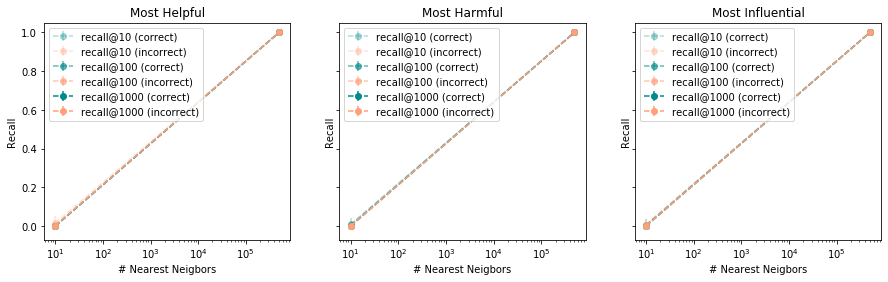

<Figure size 432x288 with 0 Axes>

In [1]:
import self_code

self_code.recall_main(ks = [10])

# Example Run: Combine output + Recall + Viz, mode = pred_feature

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Total Correct Keys:  52
Total Incorrect Keys:  48
Recall - correct
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11

 10%|▉         | 5/52 [00:08<01:17,  1.64s/it]

ValueError('`harmful_indices` have only 57 elements whereas 1000 is needed') at test_index 4


100%|██████████| 52/52 [01:34<00:00,  1.82s/it]


Recall - incorrect
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.1

100%|██████████| 48/48 [01:28<00:00,  1.84s/it]


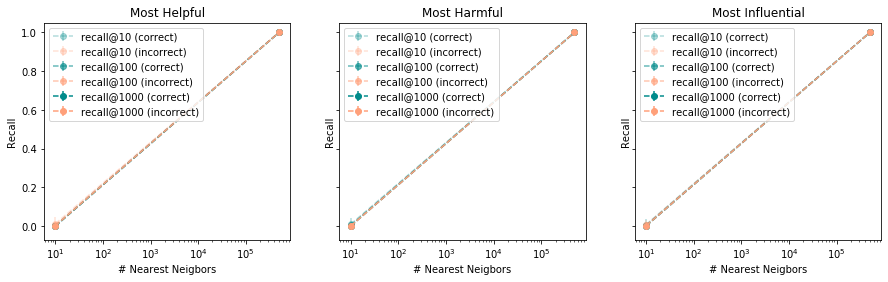

In [1]:
import self_code

self_code.recall_main(ks = [10], mode = "pred_feature", figname = "test_recall@m_pred_feat")

# Example Run: Recall @ m Step by Step, mode = feature

In [12]:
ks = [10, 100, 1000, 5000, 10000, 50000, 100000]
ms = [10,100, 1000]
recall_dict_correct = recall(ms,ks,correct_output_collections)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

 10%|▉         | 5/52 [05:36<46:10, 58.94s/it]  

ValueError('`harmful_indices` have only 57 elements whereas 1000 is needed') at test_index 4


 48%|████▊     | 25/52 [33:13<37:27, 83.23s/it]

KeyboardInterrupt: 

In [23]:
ks = [10, 100, 1000, 5000, 10000, 50000, 100000]
ms = [10,100, 1000]
recall_dict_incorrect = recall(ms,ks,incorrect_output_collections)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

100%|██████████| 28/28 [04:17<00:00,  9.18s/it]


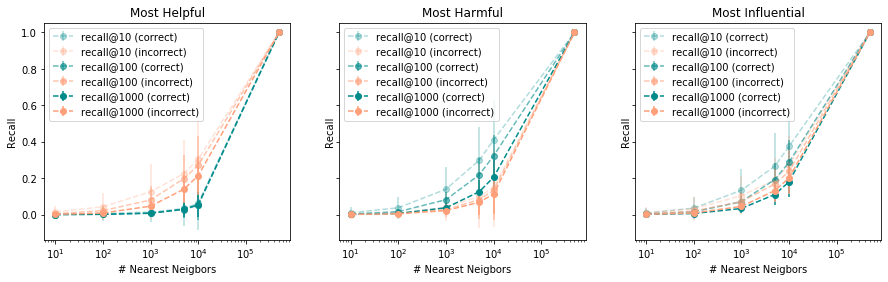

<Figure size 432x288 with 0 Axes>

In [99]:
#import torch
#torch.save(recall_dict_correct, "recall_dict_correct.pth")
#torch.save(recall_dict_incorrect, "recall_dict_incorrect.pth")

recall_m_viz(recall_dict_correct, recall_dict_incorrect, 
             ks = [10, 100, 1000, 5000, 10000] )

# Bla

In [ ]:
import torch
torch.save(recall_dict_correct, "recall_dict_correct.pth")

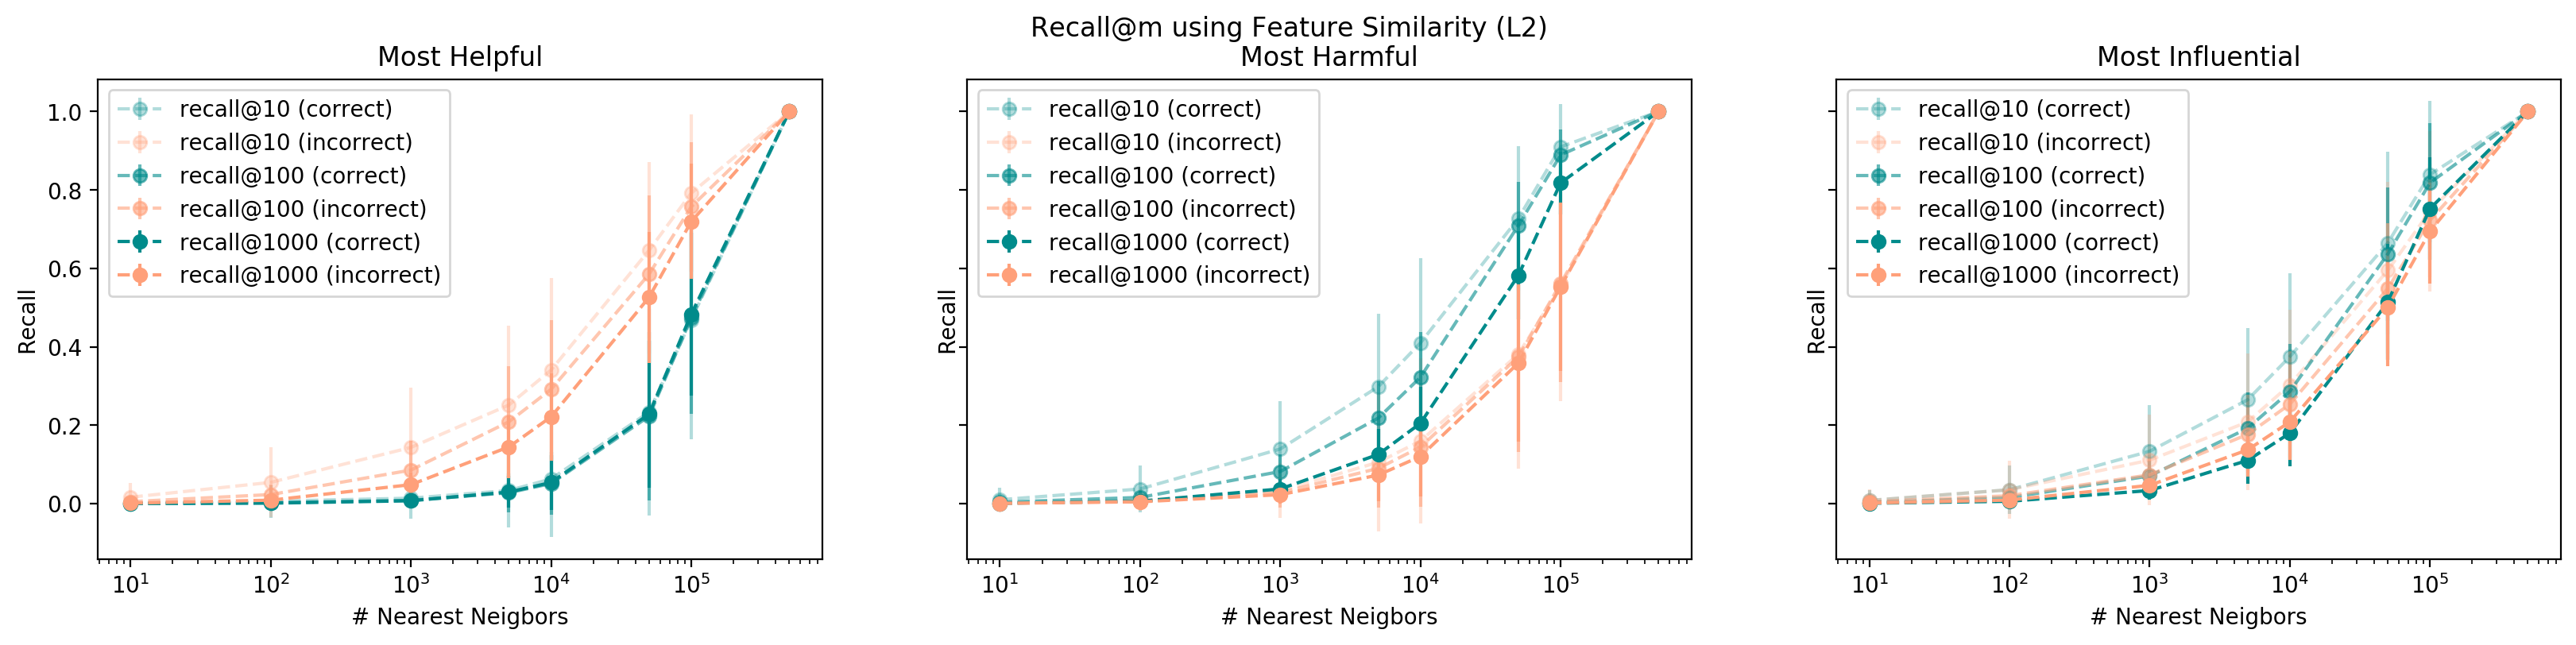

In [4]:
import torch
recall_dict_correct = torch.load("experiments_outputs/normal - L2/recall_dict_correct_feature.pth")
recall_dict_incorrect = torch.load("experiments_outputs/normal - L2/recall_dict_incorrect_feature.pth")

import self_code
self_code.recall_m_viz(recall_dict_correct, recall_dict_incorrect, 
                       super_title = "Recall@m using Feature Similarity (L2)",
                       figname = "recall@m_feature_similar_L2")

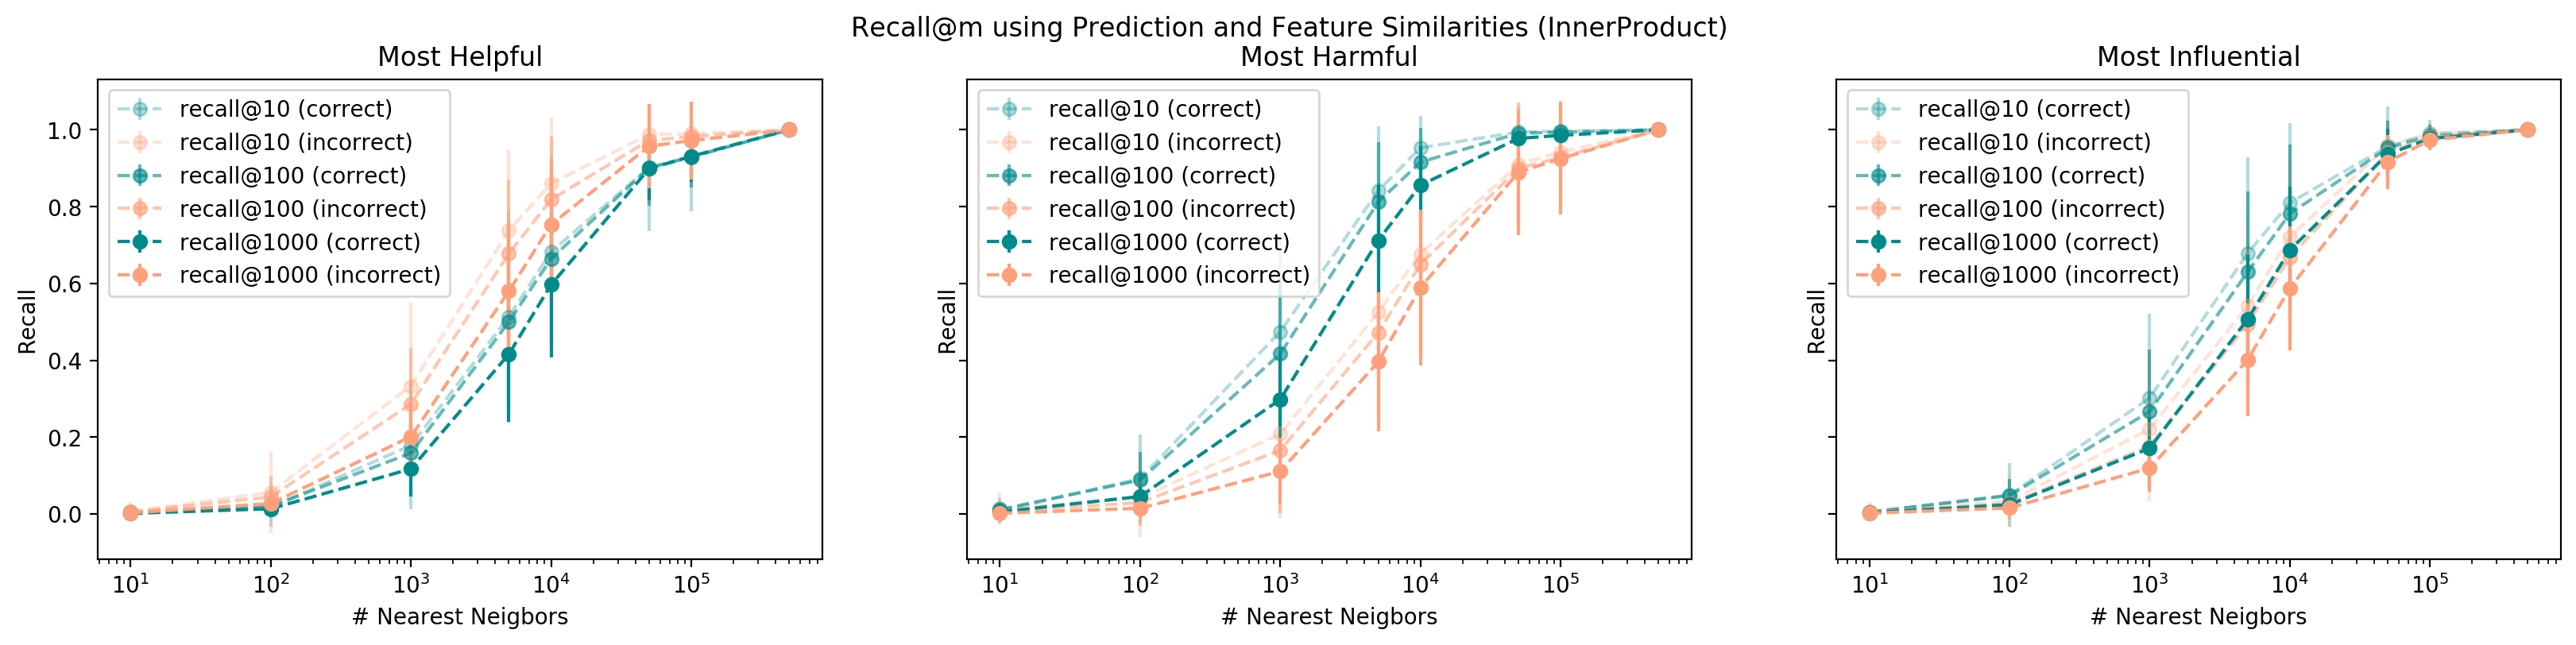

In [2]:
import torch
recall_dict_correct = torch.load("experiments_outputs/softmax - IP - mixed/recall_dict_correct_pred_feature.pth")
recall_dict_incorrect = torch.load("experiments_outputs/softmax - IP - mixed/recall_dict_incorrect_pred_feature.pth")

import self_code
self_code.recall_m_viz(recall_dict_correct, recall_dict_incorrect, 
                       super_title = "Recall@m using Prediction and Feature Similarities (InnerProduct)",
                       figname = "recall@m_pred_feature_dis_n_similar_InnerProduct")

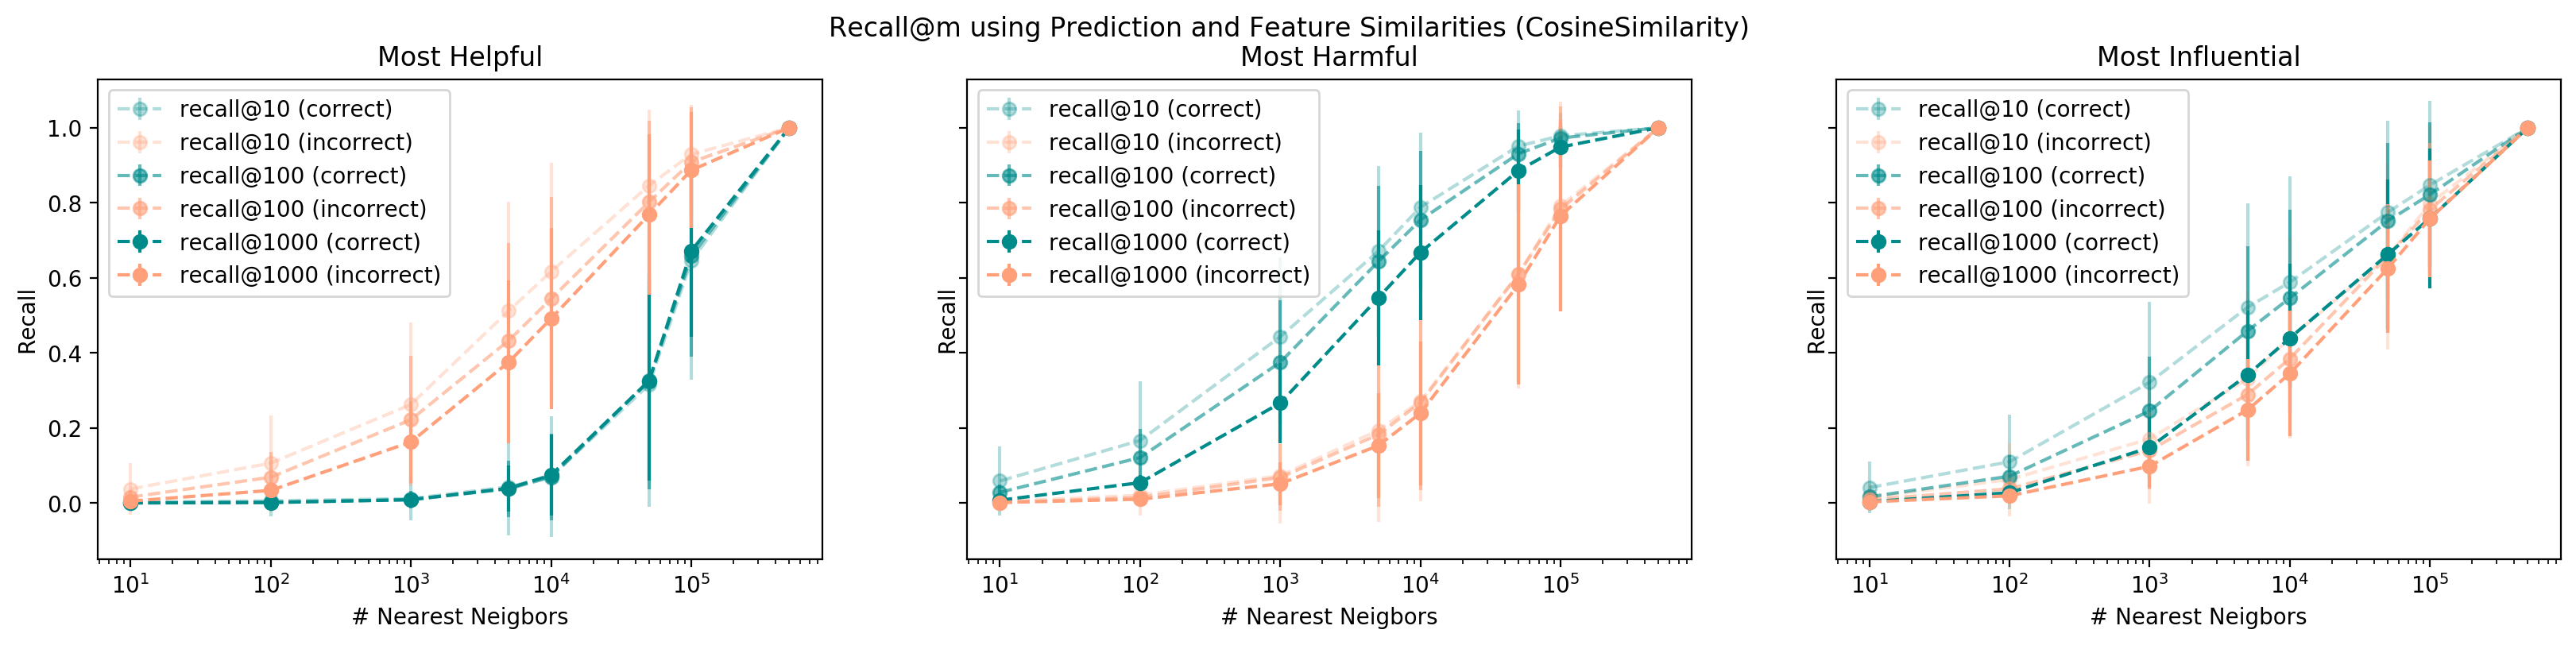

In [7]:
import torch
recall_dict_correct = torch.load("experiments_outputs/softmax - COS - mixed/recall_dict_correct_pred_feature_dis_n_similar_cosine_similarity.pth")
recall_dict_incorrect = torch.load("experiments_outputs/softmax - COS - mixed/recall_dict_incorrect_pred_feature_dis_n_similar_cosine_similarity.pth")

import self_code
self_code.recall_m_viz(recall_dict_correct, recall_dict_incorrect, 
                       super_title = "Recall@m using Prediction and Feature Similarities (CosineSimilarity)",
                       figname = "recall@m_pred_feature_dis_n_similar_CosineSimilarity")

Total Correct Keys:  52
Total Incorrect Keys:  48
Recall - correct
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11

 10%|▉         | 5/52 [00:34<04:47,  6.12s/it]

ValueError('`harmful_indices` have only 57 elements whereas 1000 is needed') at test_index 4


100%|██████████| 52/52 [07:10<00:00,  8.28s/it]


Recall - incorrect
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.1

100%|██████████| 48/48 [06:35<00:00,  8.25s/it]


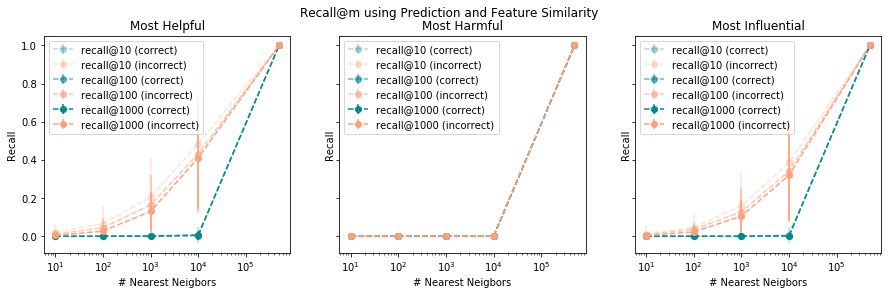

In [6]:
import self_code

self_code.recall_main(ks = [10, 100, 1000, 10000], 
                      similarity = "pred_feature", 
                      figname = "test_recall@m_pred_feat_softmax_10K")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Total Correct Keys:  52
Total Incorrect Keys:  48
Recall - correct
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11

  0%|          | 0/52 [00:00<?, ?it/s]

Recall - incorrect
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.1


  0%|          | 0/48 [00:00<?, ?it/s]

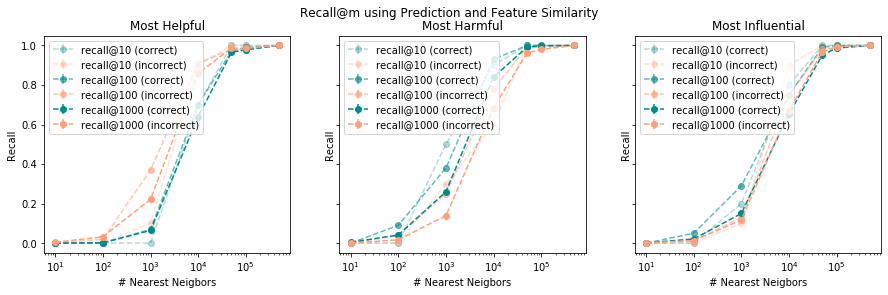

In [1]:
import self_code

self_code.recall_main(ks = [10, 100, 1000, 10000, 50000, 100000], 
                      similarity = "pred_feature", 
                      mixed_direction = True,
                      figname = "test_recall@m_pred_feat_softmax_100K_1ex_IP_mix")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Total Correct Keys:  52
Total Incorrect Keys:  48
Recall - correct
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11

  0%|          | 0/52 [00:00<?, ?it/s]

Recall - incorrect
Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.1


  0%|          | 0/48 [00:00<?, ?it/s]

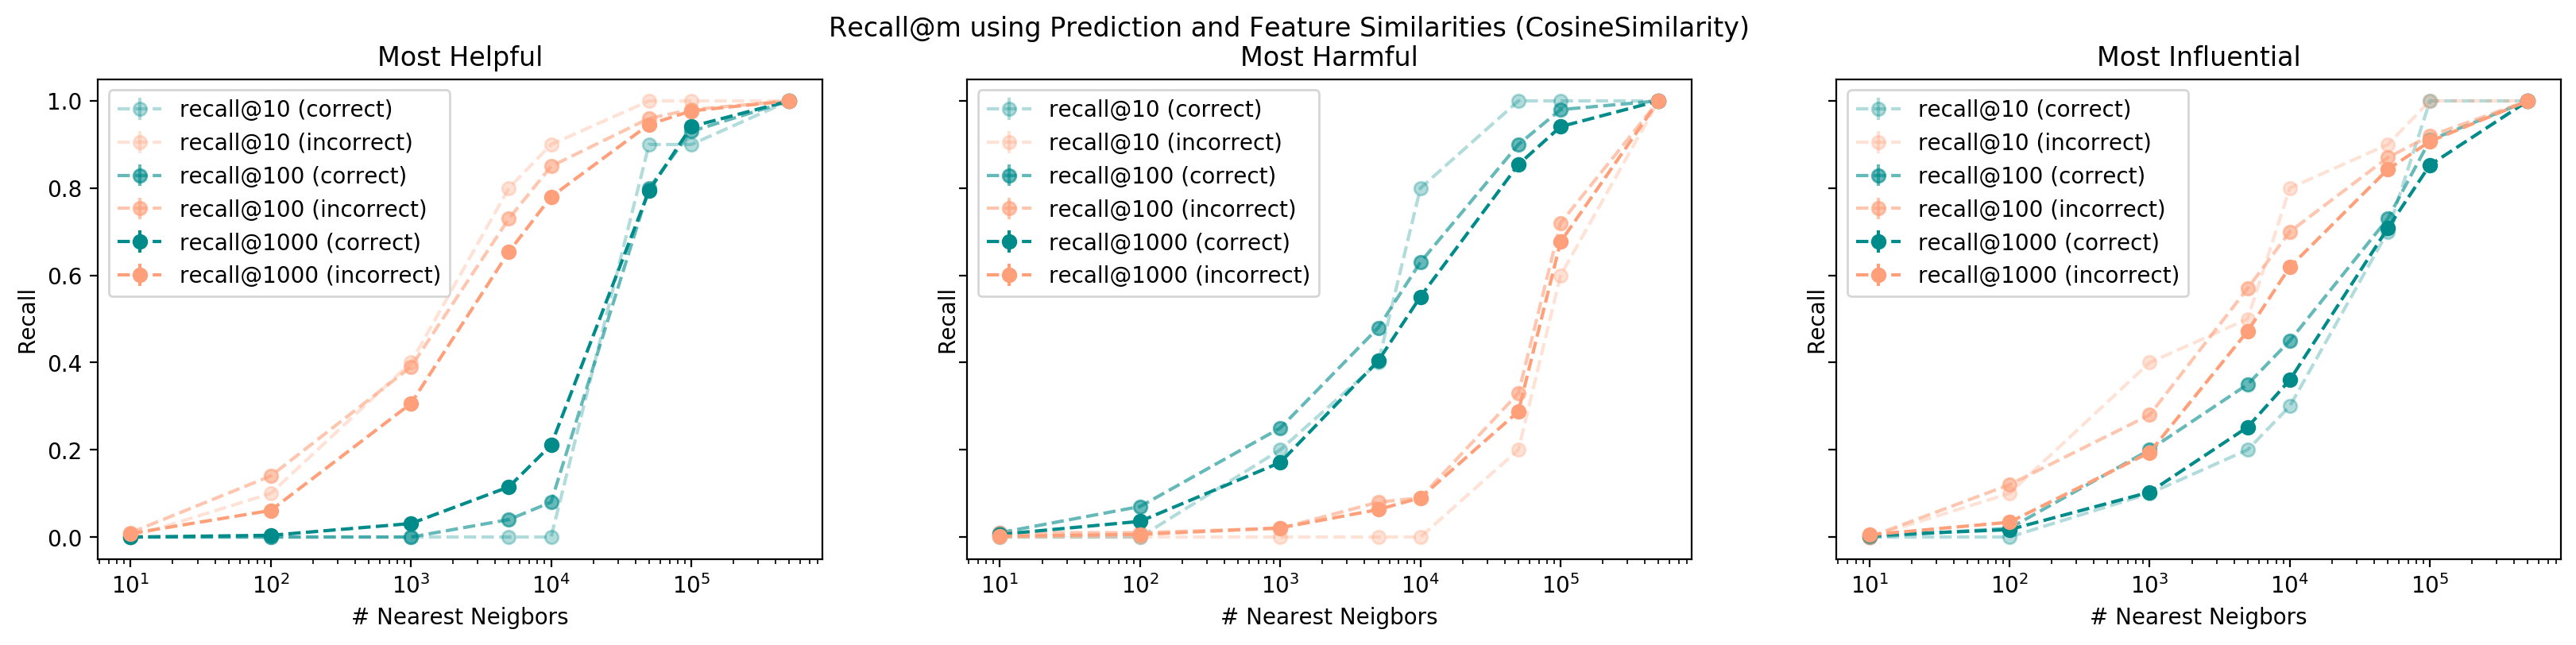

In [1]:
import self_code

self_code.recall_main(similarity = "pred_feature", 
                      metric = "cosine_similarity",
                      mixed_direction = True,
                      figname = "test_recall@m_pred_feat_softmax_100K_1ex_COS_mix")

# Outer Product

In [6]:
import numpy as np
a = [[1,2,3], [3,2,1]]
b = [[4,5,6], [6,5,4]]

In [10]:
print(a)
print(b)

[[1, 2, 3], [3, 2, 1]]
[[4, 5, 6], [6, 5, 4]]


In [13]:
np.outer(a,b)

array([[ 4,  5,  6,  6,  5,  4],
       [ 8, 10, 12, 12, 10,  8],
       [12, 15, 18, 18, 15, 12],
       [12, 15, 18, 18, 15, 12],
       [ 8, 10, 12, 12, 10,  8],
       [ 4,  5,  6,  6,  5,  4]])

In [11]:
np.reshape(np.outer(a,b), -1)

array([ 4,  5,  6,  6,  5,  4,  8, 10, 12, 12, 10,  8, 12, 15, 18, 18, 15,
       12, 12, 15, 18, 18, 15, 12,  8, 10, 12, 12, 10,  8,  4,  5,  6,  6,
        5,  4])

In [8]:
np.einsum('bi,bj->bij', a, b)

array([[[ 4,  5,  6],
        [ 8, 10, 12],
        [12, 15, 18]],

       [[18, 15, 12],
        [12, 10,  8],
        [ 6,  5,  4]]])

In [9]:
np.reshape(np.einsum('bi,bj->bij', a, b), (2,-1))

array([[ 4,  5,  6,  8, 10, 12, 12, 15, 18],
       [18, 15, 12, 12, 10,  8,  6,  5,  4]])

In [17]:
features = np.array([[1,2,3,4], [5,6,7,8]])
features_arr = []
for i in range(len(features)):
    tmp = list(features[i])
    tmp.insert(0, 1.0)
    features_arr.append(tmp)

In [18]:
features_arr

[[1.0, 1, 2, 3, 4], [1.0, 5, 6, 7, 8]]

# Faiss Testing metrics

In [13]:
import faiss
import numpy as np
dataSetI = [.1, .2, .3]
dataSetII = [.4, .5, .6]
#dataSetII = [.1, .2, .3]

x = np.array([dataSetI]).astype(np.float32)
q = np.array([dataSetII]).astype(np.float32)
index = faiss.index_factory(3, "Flat", faiss.METRIC_INNER_PRODUCT)
index.ntotal
faiss.normalize_L2(x)
index.add(x)
faiss.normalize_L2(q)
faiss.write_index(index, "testFaiss.index")

distance, index = index.search(q, 5)
print('Distance by FAISS:{}'.format(distance))

Distance by FAISS:[[ 9.7463191e-01 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
  -3.4028235e+38]]


In [8]:
import faiss
index = faiss.index_factory(3, "Flat", faiss.METRIC_L2)
index.metric_type # 0 for METRIC_INNER_PRODUCT, 1 for METRIC_L2
# See https://github.com/facebookresearch/faiss/blob/main/faiss/MetricType.h

1

In [2]:
import faiss
import numpy as np
a = faiss.read_index("testFaiss.index")
distance, _ = a.search(q, 5)
print('Distance by FAISS:{}'.format(distance))

NameError: name 'q' is not defined

This shows that we don't have to care about metrics when loading index

# Faiss Cosine Similarity - Github Example

In [10]:
import faiss
import numpy as np
dataSetI = [.1, .2, .3]
dataSetII = [.4, .5, .6]
#dataSetII = [.1, .2, .3]

x = np.array([dataSetI]).astype(np.float32)
q = np.array([dataSetII]).astype(np.float32)
index = faiss.index_factory(3, "Flat", faiss.METRIC_INNER_PRODUCT)
index.ntotal
faiss.normalize_L2(x)
index.add(x)
faiss.normalize_L2(q)
distance, index = index.search(q, 5)
print('Distance by FAISS:{}'.format(distance))

#To Tally the results check the cosine similarity of the following example

from scipy import spatial

result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
print('Distance by Spatial:{}'.format(result))

Distance by FAISS:[[ 9.7463191e-01 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
  -3.4028235e+38]]
Distance by Spatial:0.9746318461970764
